In [77]:
# Import dependencies
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from scipy.stats import norm
import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Importing Dependencies for DB connection
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
import config
import psycopg2

In [194]:
# Establish a connection to the database
conn = psycopg2.connect(
    host = config.config['host'],
    port = config.config['port'], 
    dbname = config.config['dbname'], 
    user = config.config['user'], 
    password = config.config['password'])

print("Postgres Connected")

Postgres Connected


In [79]:
# Import Data from AWS database
df= pd.read_sql_query('SELECT ref_date,total_vacancies FROM "canada_vacancies"', con=conn)
df

,ref_date,total_vacancies
0,2015-04-01,451925.0
1,2015-07-01,407865.0
2,2015-10-01,358755.0
3,2016-01-01,330215.0
4,2016-04-01,391190.0
5,2016-07-01,404860.0
6,2016-10-01,381010.0
7,2017-01-01,387080.0
8,2017-04-01,459685.0
9,2017-07-01,467395.0


In [80]:
# remove Q3 2020- Q22021
df = df[0:20]
df

,ref_date,total_vacancies
0,2015-04-01,451925.0
1,2015-07-01,407865.0
2,2015-10-01,358755.0
3,2016-01-01,330215.0
4,2016-04-01,391190.0
5,2016-07-01,404860.0
6,2016-10-01,381010.0
7,2017-01-01,387080.0
8,2017-04-01,459685.0
9,2017-07-01,467395.0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ref_date         20 non-null     object 
 1   total_vacancies  20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 448.0+ bytes


In [82]:
#  convert the REF_DATE column into a datetime object
df['ref_date'] = pd.to_datetime(df['ref_date'], format='%Y-%m')
df.head()

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ref_date,total_vacancies
0,2015-04-01,451925.0
1,2015-07-01,407865.0
2,2015-10-01,358755.0
3,2016-01-01,330215.0
4,2016-04-01,391190.0


In [83]:
df.set_index('ref_date', inplace=True)
df.shape

(20, 1)

## Time series Analysis 

In [84]:
#visualize the time series data

(array([16436., 16801., 17167., 17532., 17897., 18262.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

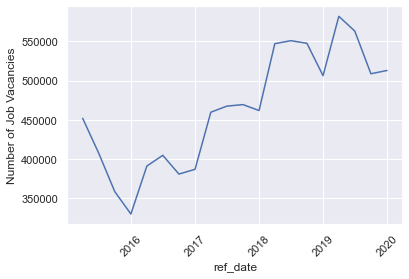

In [85]:
sns.lineplot(data= df, x='ref_date', y= 'total_vacancies')
plt.ylabel('Number of Job Vacancies')
plt.xticks(rotation=45)

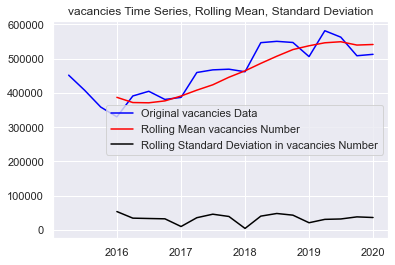

In [86]:
'''check for stationary
A stationary time series will not have any trends or seasonal patterns
We will use the Dickey Fuller test to check for stationarity in our data '''

rolling_mean = df.rolling(4).mean()
rolling_std = df.rolling(4).std()

#First, let’s make a Matplotlib plot of our time series
plt.plot(df, color="blue",label="Original vacancies Data")
# then the rolling mean
plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
#And finally, the rolling standard deviation:
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
#Let’s then add a title:
plt.title("vacancies Time Series, Rolling Mean, Standard Deviation")
#And a legend:
plt.legend(loc="best")

In [87]:
#We will use the Dickey Fuller test to check for stationarity in our data
from statsmodels.tsa.stattools import adfuller
df_test=df.iloc[:,0].values
adft = adfuller(df_test,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -1.354507              Test Statistics
1   0.603882                      p-value
2   7.000000             No. of lags used
3  12.000000  Number of observations used
4  -4.137829          critical value (1%)
5  -3.154972          critical value (5%)
6  -2.714477         critical value (10%)


our data is not stationary as p value is higher than 0.05

In [88]:
# Checking for autocorrelation in time series data
# This is a measure of how correlated time series data is at a given point in time with past values
autocorrelation_lag1 = df['total_vacancies'].autocorr(lag=1)
print("One Quarter Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = df['total_vacancies'].autocorr(lag=2)
print("Two Quaretrs Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = df['total_vacancies'].autocorr(lag=3)
print("Three Quaretrs Lag: ", autocorrelation_lag3)

autocorrelation_lag4 = df['total_vacancies'].autocorr(lag=4)
print("Four Quaretrs Lag: ", autocorrelation_lag4)

One Quarter Lag:  0.8417507442893579
Two Quaretrs Lag:  0.6965572514223229
Three Quaretrs Lag:  0.6788911778498717
Four Quaretrs Lag:  0.7749030868093133


the data is autocorrelated

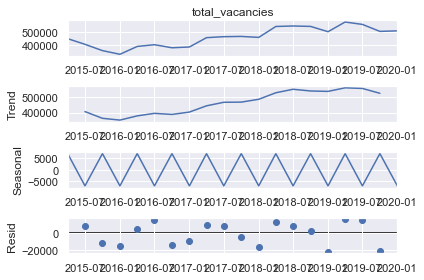

In [89]:
#Check for Trend decomposition is another useful way to visualize the trends in time series data
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['total_vacancies'],model='additive', period=2)
decompose.plot()
plt.show()

From this plot, we can clearly see the increasing trend in number of vacancies and the seasonality patterns in the rise and fall in values each year.

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

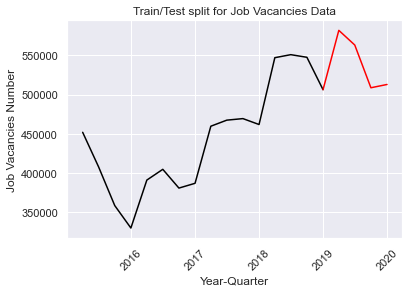

In [90]:
# Forescasting
df['ref_date']=df.index
train = df[df['ref_date'] < "2019-04-01"]
train['train'] = train['total_vacancies']
del train['ref_date']
del train['total_vacancies']

test = df[df['ref_date'] >= "2019-04-01"]
del test['ref_date']
test['test'] = test['total_vacancies']
del test['total_vacancies']

plt.plot(train, color = "black")
plt.plot(pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test]), color = "red")
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
sns.set()
plt.show()

In [91]:
pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test])

,test
ref_date,
2019-01-01,506140.0
2019-04-01,581595.0
2019-07-01,562910.0
2019-10-01,508590.0
2020-01-01,512760.0


## SARIMA

source: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [92]:
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [143]:
# Dataset
data = df
data.index = data.ref_date
# Set the frequency
data.index.freq="QS-OCT"

# Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
mod = sm.tsa.statespace.SARIMAX(train, trend='t', order=(1,0,1),seasonal_order=(1, 1, 1, 2))
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             train   No. Observations:                   16
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 2)   Log Likelihood                -173.868
Date:                           Sun, 21 Nov 2021   AIC                            359.736
Time:                                   19:20:34   BIC                            363.571
Sample:                               04-01-2015   HQIC                           359.381
                                    - 01-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -977.1508      0.000  -2.77e+06      0.000    -977.152    -977.150
ar.L1         -0.6853      0.079     -8.722

In [144]:
# forecast values for test data
forecast = res.predict(test.index[0],test.index[-1], dynamic=True)
forecast = pd.DataFrame(forecast.values,index = test.index,columns=['predicted_vacancies'])
forecast.head()

,predicted_vacancies
ref_date,
2019-04-01,587407.392035
2019-07-01,549985.454825
2019-10-01,535895.200785
2020-01-01,495415.010295


In [145]:
# create dataframe for results
output = test.merge(forecast, how='inner', left_index=True, right_index=True)
output.head()

,test,predicted_vacancies
ref_date,,
2019-04-01,581595.0,587407.392035
2019-07-01,562910.0,549985.454825
2019-10-01,508590.0,535895.200785
2020-01-01,512760.0,495415.010295


In [146]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(output.test,output.predicted_vacancies, squared=False)
rms

17658.216408647935

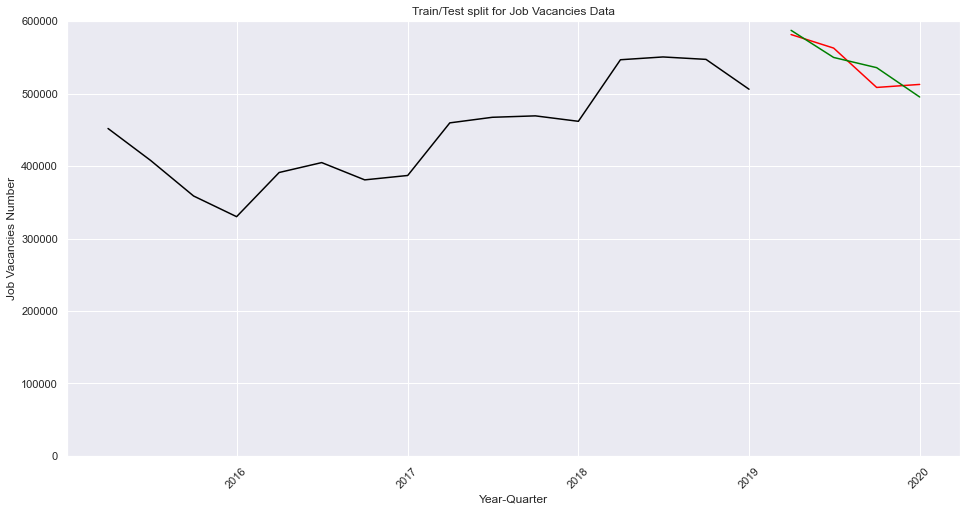

In [130]:
#visualize results
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast['predicted_vacancies'],color= 'green')
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
sns.set()
plt.show()

In [131]:
# check model accuaracy with actual values from statCan
Actual=[560215,553480,731905]
predict_quarters=['2020-10-01','2021-01-01','2021-04-01']

forecast_data=[]
counter=0
for i in predict_quarters:
    forecast_test = res.predict(i)
    forecast_data.append(forecast_test)
    counter +=1
    
forecast_data

[2020-10-01    522737.441305
 Freq: QS-OCT, dtype: float64,
 2021-01-01    481961.986259
 Freq: QS-OCT, dtype: float64,
 2021-04-01    560978.298278
 Freq: QS-OCT, dtype: float64]

In [132]:
forecast_data[2].index # list of dataframes

DatetimeIndex(['2021-04-01'], dtype='datetime64[ns]', freq='QS-OCT')

In [133]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_data]

[522737, 481961, 560978]

In [134]:
# create results dataframe
forecast_df= pd.DataFrame({'Predicted Value':[int(f.values[0]) for f in forecast_data], 'Actual Value': Actual}, index=predict_quarters)
forecast_df.head()

,Predicted Value,Actual Value
2020-10-01,522737,560215
2021-01-01,481961,553480
2021-04-01,560978,731905


In [157]:
# Function to apply timeseries model on province level
def province_vac (province):
    import warnings
    warnings.filterwarnings("ignore")
    
    # Import Data from AWS database
    df_prov = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
    #  convert the REF_DATE column into a datetime object
    df_prov['ref_date'] = pd.to_datetime(df_prov['ref_date'], format='%Y-%m')
    #select province data 
    prov_vac= df_prov.loc[df_prov['geo']== str(province),:] 
    # drop all unnecessary columns
    prov_vac = prov_vac.loc[:,['ref_date','total_vacancies']]
    # aggregate total vacancies per quarter
    prov_vac= prov_vac.groupby(prov_vac['ref_date']).sum()
    #remove Q32020 onwards
    prov_vac= prov_vac.loc['2015-04-01':'2020-01-01']
    # rename columns
    prov_vac.rename(columns={'total_vacancies':f'{province}_total_vacancies'}, inplace=True)
    #visualize the time series data
    sns.lineplot(data= prov_vac, x='ref_date', y= f'{province}_total_vacancies')
    plt.ylabel('Number of Job Vacancies')
    plt.xticks(rotation=45)
    
    #check for stationary using the Dickey Fuller test to check for stationarity in our data
    rolling_mean = prov_vac.rolling(4).mean()
    rolling_std = prov_vac.rolling(4).std()
    #First, make a Matplotlib plot of our time series
    plt.plot(prov_vac, color="blue",label="Original vacancies Data")
    # then the rolling mean
    plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
    #And finally, the rolling standard deviation:
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
    #add a title:
    plt.title(f'{province} vacancies Time Series, Rolling Mean, Standard Deviation')
    #And a legend:
    plt.legend(loc="best")
    #use the Dickey Fuller test to check for stationarity in our data
    from statsmodels.tsa.stattools import adfuller
    prov_vac_test=prov_vac.iloc[:,0].values
    adft_prov = adfuller(prov_vac_test,autolag="AIC")
    output_prov_df = pd.DataFrame({"Values":[adft_prov[0],adft_prov[1],adft_prov[2],adft_prov[3], adft_prov[4]['1%'], adft_prov[4]['5%'], adft_prov[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print('Stationary Test Results')
    print(output_prov_df)
    
    # Checking for autocorrelation in time series data
    print('Autocorrelation Results')
    autocorrelation_lag1_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=1)
    print("One Quarter Lag: ", autocorrelation_lag1_prov)
    autocorrelation_lag2_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=2)
    print("Two Quaretrs Lag: ", autocorrelation_lag2_prov)
    autocorrelation_lag3_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=3)
    print("Three Quaretrs Lag: ", autocorrelation_lag3_prov)
    autocorrelation_lag4_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=4)
    print("Four Quaretrs Lag: ", autocorrelation_lag4_prov)
    
    #Check for Trend decomposition to visualize the trends in time series data
    from statsmodels.tsa.seasonal import seasonal_decompose
    decompose_prov = seasonal_decompose(prov_vac[f'{province}_total_vacancies'],model='additive', period=2)
    decompose_prov.plot()
    print('Trend Decomposition Visualization')
    plt.show()
    
    # Forescasting
    prov_vac['ref_date']=prov_vac.index
    train_prov = prov_vac[prov_vac['ref_date'] < "2019-04-01"]
    train_prov[f'train_{province}'] = train_prov[f'{province}_total_vacancies']
    del train_prov['ref_date']
    del train_prov[f'{province}_total_vacancies']

    test_prov = prov_vac[prov_vac['ref_date'] >= "2019-04-01"]
    del test_prov['ref_date']
    test_prov[f'test_{province}'] = test_prov[f'{province}_total_vacancies']
    del test_prov[f'{province}_total_vacancies']

    # Register converters to avoid warnings
    pd.plotting.register_matplotlib_converters()
    plt.rc("figure", figsize=(16,8))
    plt.rc("font", size=14)
    
    # Dataset
    data_prov = prov_vac
    data_prov.index = data_prov.ref_date
    # Set the frequency
    data_prov.index.freq="QS-OCT"

    # Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
    mod_prov = sm.tsa.statespace.SARIMAX(train_prov, trend='t', order=(0,1,0),seasonal_order=(1, 1, 1, 2))
    res_prov = mod_prov.fit(disp=False)s
    print(res_prov.summary())
    
    # produce forecast results
    forecast_prov = res_prov.predict(test_prov.index[0],test_prov.index[-1], dynamic=True)
    forecast_prov = pd.DataFrame(forecast_prov.values,index = test_prov.index,columns=[f'Prediction_{province}'])
    output_prov = test_prov.merge(forecast_prov, how='inner', left_index=True, right_index=True)
    print('Forecast Results')
    
    
    #plot results
    plt.plot(train_prov, color = "black")
    plt.plot(test_prov, color = "red")
    plt.plot(forecast_prov[f'Prediction_{province}'],color= 'green')
    plt.title(f"Train/Test/Forecast split for {province} Job Vacancies Data")
    plt.ylabel("Job Vacancies Number")
    plt.xlabel('Year-Quarter')
    plt.xticks(rotation=45)
    plt.ylim(ymin=0)
    sns.set()
    plt.show()
    
    from sklearn.metrics import mean_squared_error

    rms_prov = mean_squared_error(output_prov[f'test_{province}'],output_prov[f'Prediction_{province}'], squared=False)
                                  
    print(f'RMSE is {rms_prov}')
    return output_prov
    
  

Stationary Test Results
      Values                       Metric
0  -1.423280              Test Statistics
1   0.571066                      p-value
2   0.000000             No. of lags used
3  19.000000  Number of observations used
4  -3.832603          critical value (1%)
5  -3.031227          critical value (5%)
6  -2.655520         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.7964151968963387
Two Quaretrs Lag:  0.7017226808381068
Three Quaretrs Lag:  0.6245300422405349
Four Quaretrs Lag:  0.725360613094493
Trend Decomposition Visualization


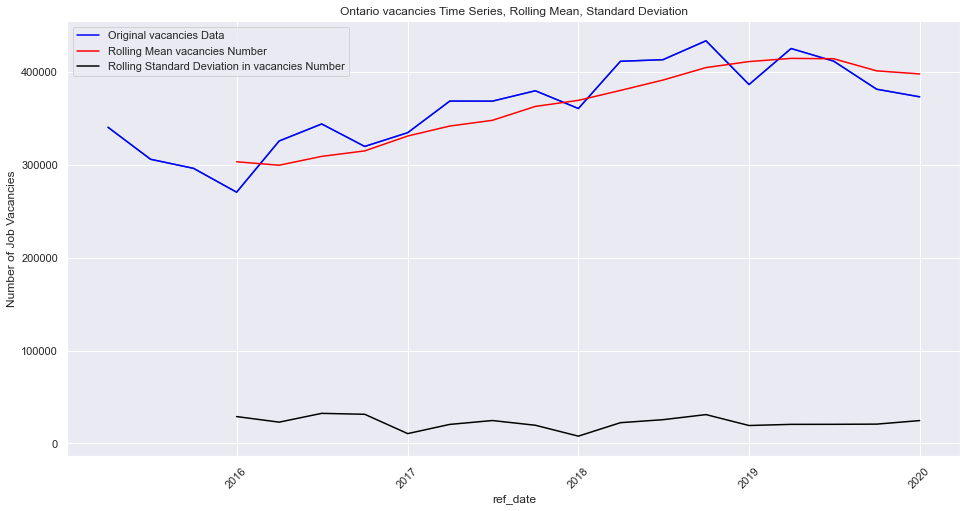

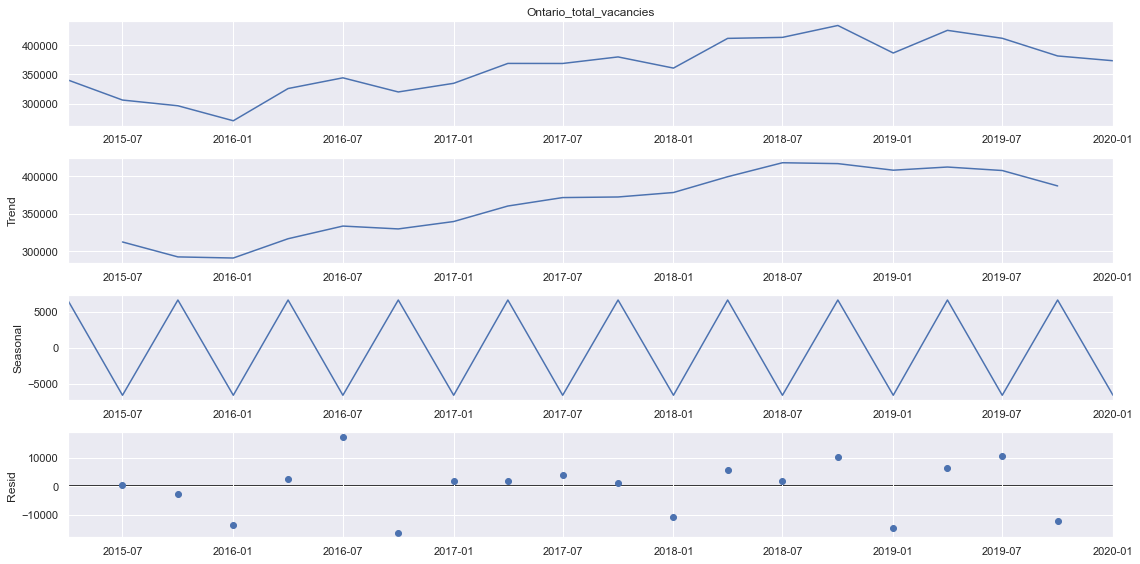

                                      SARIMAX Results                                      
Dep. Variable:                       train_Ontario   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -151.927
Date:                             Sun, 21 Nov 2021   AIC                            311.854
Time:                                     20:00:51   BIC                            314.113
Sample:                                 04-01-2015   HQIC                           311.389
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -669.1452   3527.657     -0.190      0.850   -7583.226    6244.936
ar.S.L2       -0.8181      

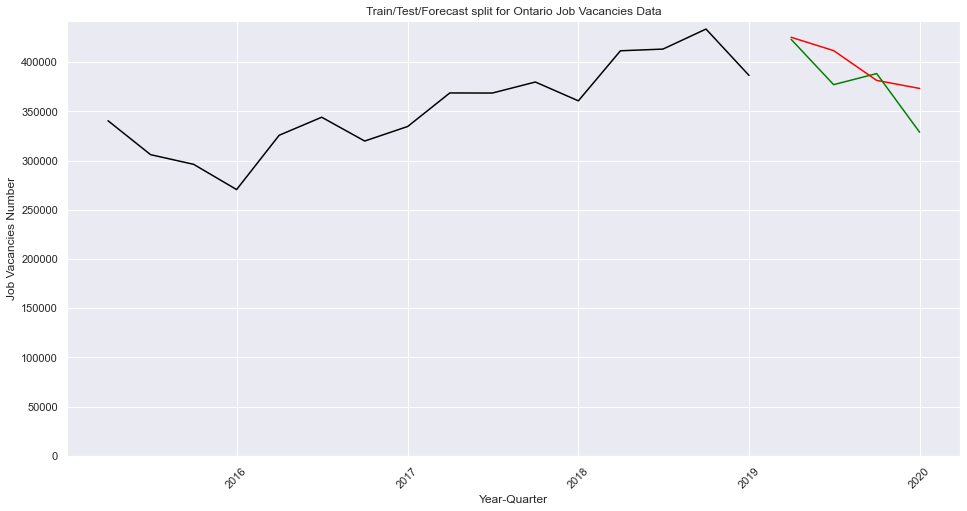

RMSE is 28408.040023885933


,test_Ontario,Prediction_Ontario
ref_date,,
2019-04-01,425185.0,423097.545808
2019-07-01,411615.0,377035.151559
2019-10-01,381370.0,388306.575538
2020-01-01,373185.0,328689.747573


In [171]:
#example output on province level
province_vac('Ontario')

Stationary Test Results
      Values                       Metric
0  -1.423280              Test Statistics
1   0.571066                      p-value
2   0.000000             No. of lags used
3  19.000000  Number of observations used
4  -3.832603          critical value (1%)
5  -3.031227          critical value (5%)
6  -2.655520         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.7964151968963387
Two Quaretrs Lag:  0.7017226808381068
Three Quaretrs Lag:  0.6245300422405349
Four Quaretrs Lag:  0.725360613094493
Trend Decomposition Visualization


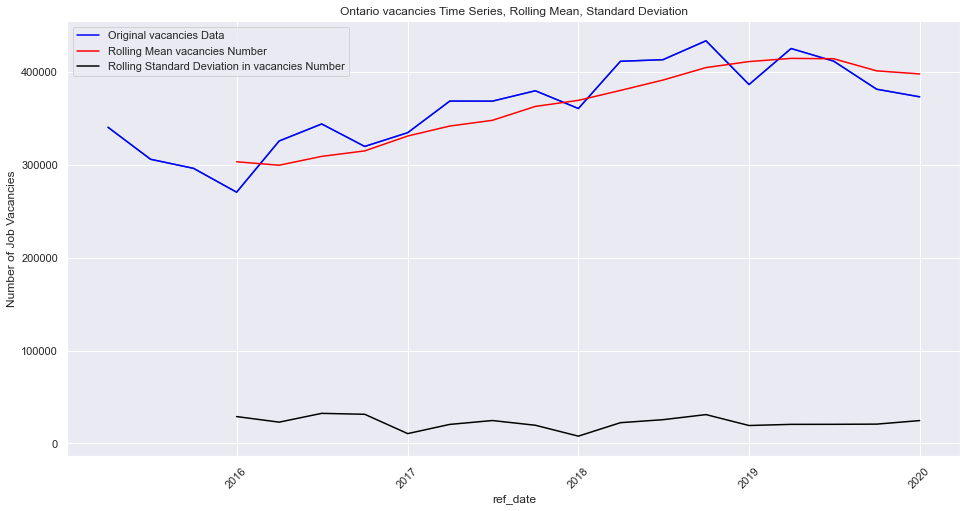

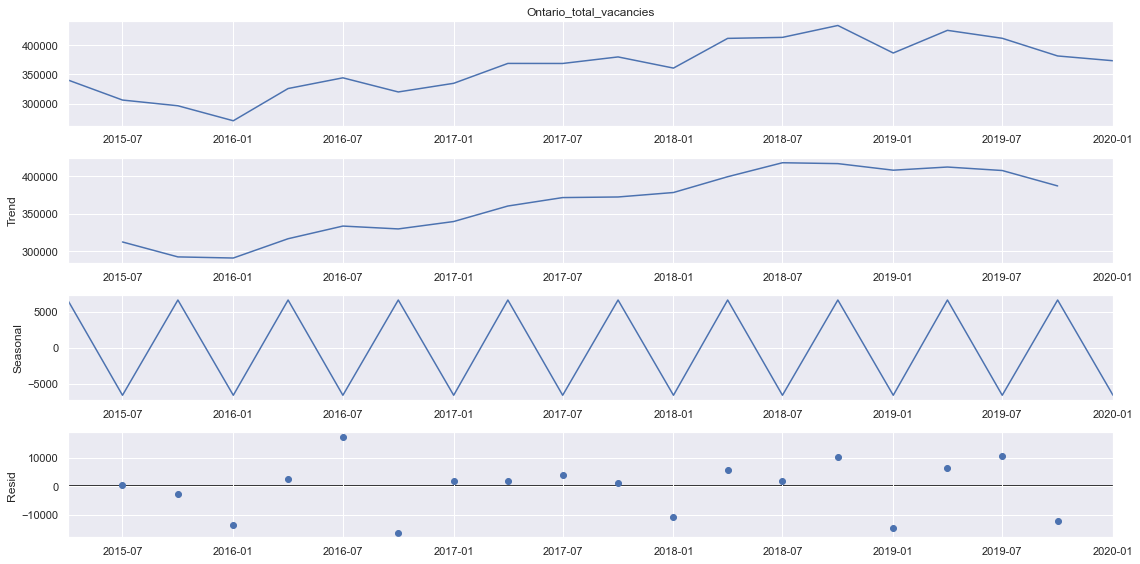

                                      SARIMAX Results                                      
Dep. Variable:                       train_Ontario   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -151.927
Date:                             Sun, 21 Nov 2021   AIC                            311.854
Time:                                     21:00:24   BIC                            314.113
Sample:                                 04-01-2015   HQIC                           311.389
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -669.1452   3527.657     -0.190      0.850   -7583.226    6244.936
ar.S.L2       -0.8181      

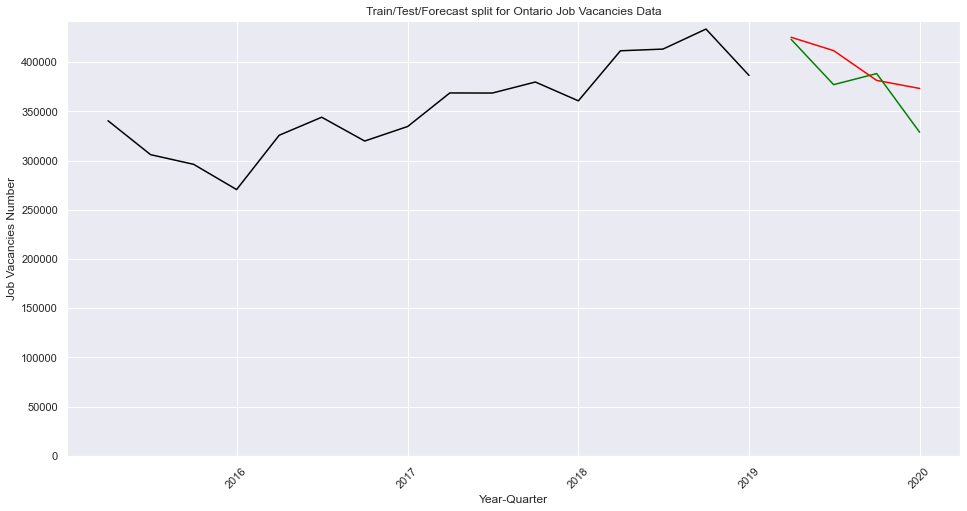

RMSE is 28408.040023885933
Stationary Test Results
      Values                       Metric
0  -1.761933              Test Statistics
1   0.399518                      p-value
2   4.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.9399001959864484
Two Quaretrs Lag:  0.880652145144762
Three Quaretrs Lag:  0.8817831939441049
Four Quaretrs Lag:  0.9363009410810416
Trend Decomposition Visualization


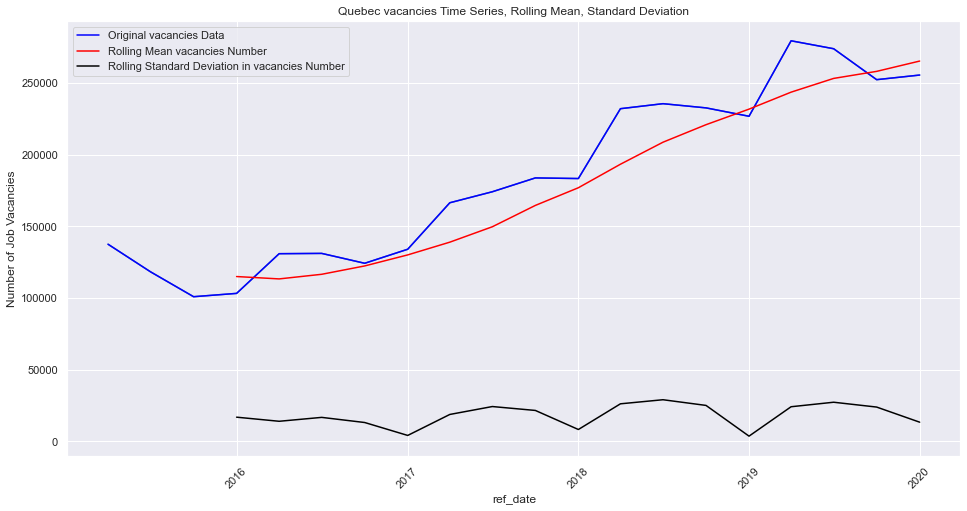

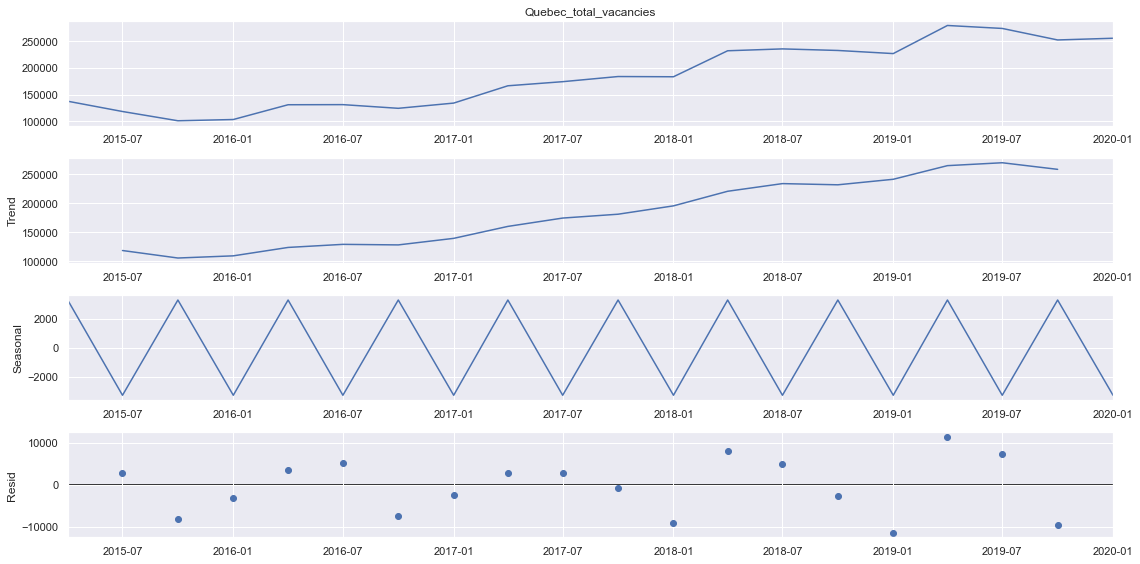

                                      SARIMAX Results                                      
Dep. Variable:                        train_Quebec   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -146.051
Date:                             Sun, 21 Nov 2021   AIC                            300.102
Time:                                     21:00:26   BIC                            302.362
Sample:                                 04-01-2015   HQIC                           299.638
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -398.8056   4062.798     -0.098      0.922   -8361.744    7564.132
ar.S.L2       -0.9412      

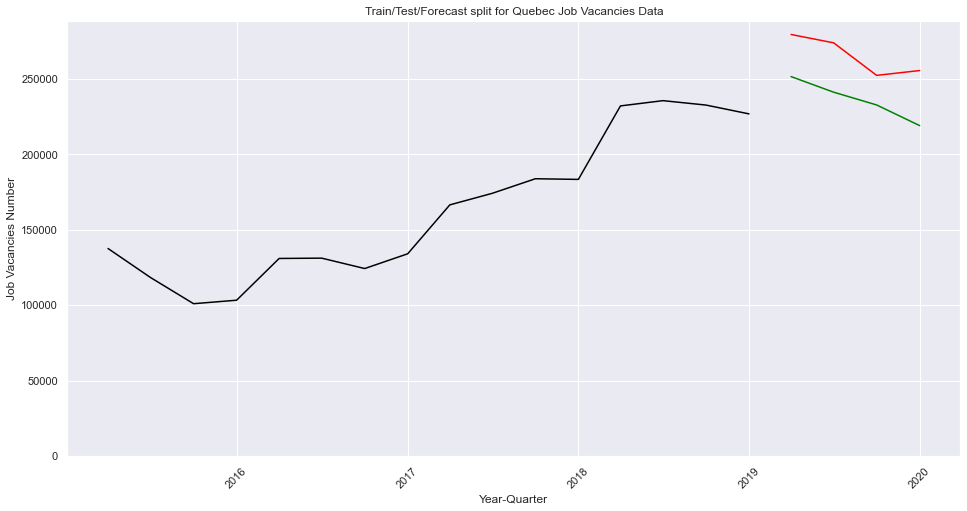

RMSE is 29877.7443647051
Stationary Test Results
      Values                       Metric
0  -3.038449              Test Statistics
1   0.031456                      p-value
2   5.000000             No. of lags used
3  14.000000  Number of observations used
4  -4.012034          critical value (1%)
5  -3.104184          critical value (5%)
6  -2.690987         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.8882003420078226
Two Quaretrs Lag:  0.7575329853246081
Three Quaretrs Lag:  0.7600231860517856
Four Quaretrs Lag:  0.7581704761525255
Trend Decomposition Visualization


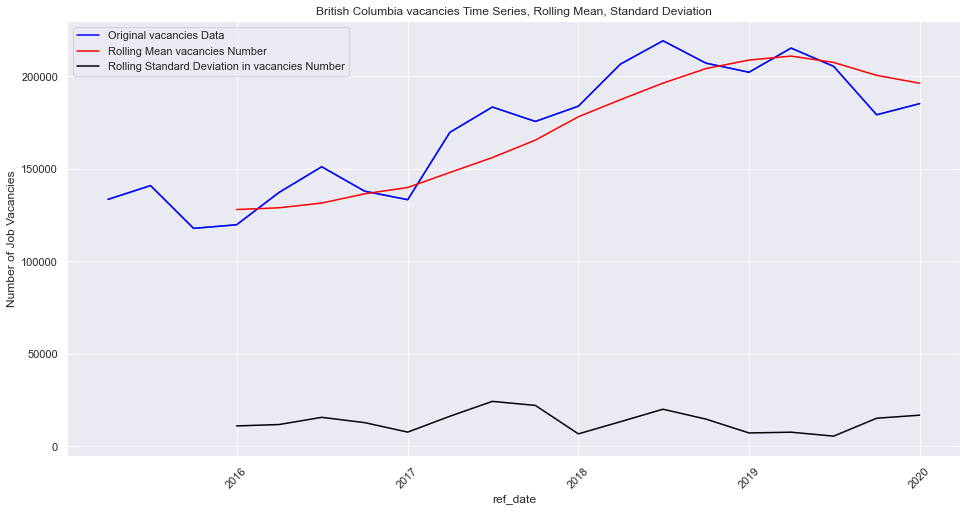

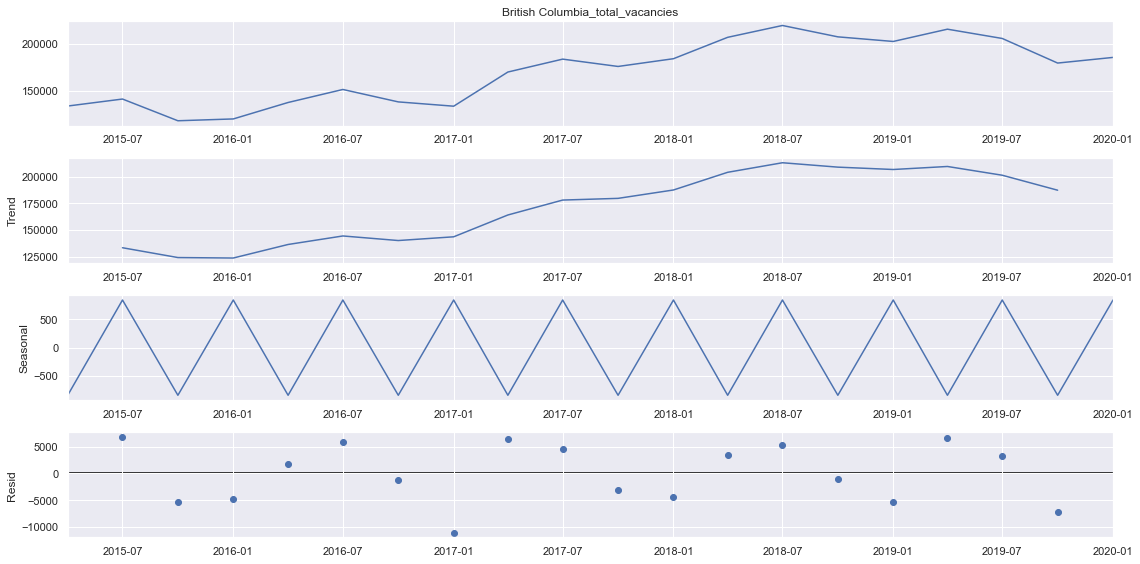

                                      SARIMAX Results                                      
Dep. Variable:              train_British Columbia   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -145.839
Date:                             Sun, 21 Nov 2021   AIC                            299.678
Time:                                     21:00:27   BIC                            301.937
Sample:                                 04-01-2015   HQIC                           299.213
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -455.2982   4980.197     -0.091      0.927   -1.02e+04    9305.709
ar.S.L2       -0.9298      

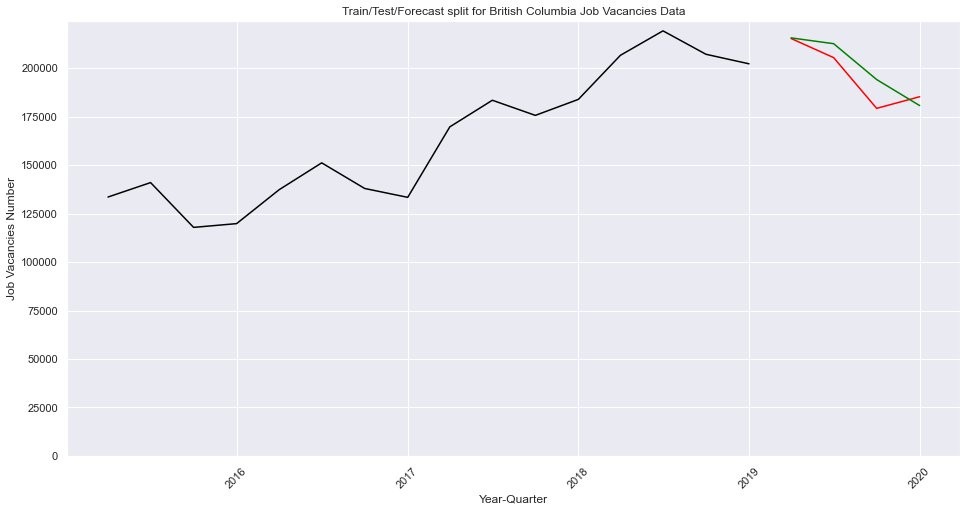

RMSE is 8567.519775183871
Stationary Test Results
      Values                       Metric
0  -1.760414              Test Statistics
1   0.400284                      p-value
2   8.000000             No. of lags used
3  11.000000  Number of observations used
4  -4.223238          critical value (1%)
5  -3.189369          critical value (5%)
6  -2.729839         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6345602643612172
Two Quaretrs Lag:  0.07396744345597699
Three Quaretrs Lag:  -0.09291663719558553
Four Quaretrs Lag:  -0.052219678089037984
Trend Decomposition Visualization


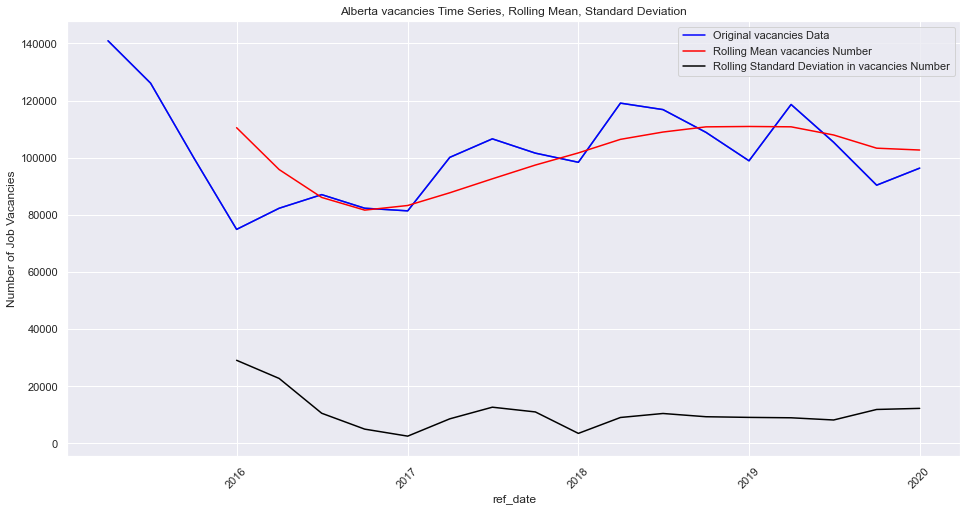

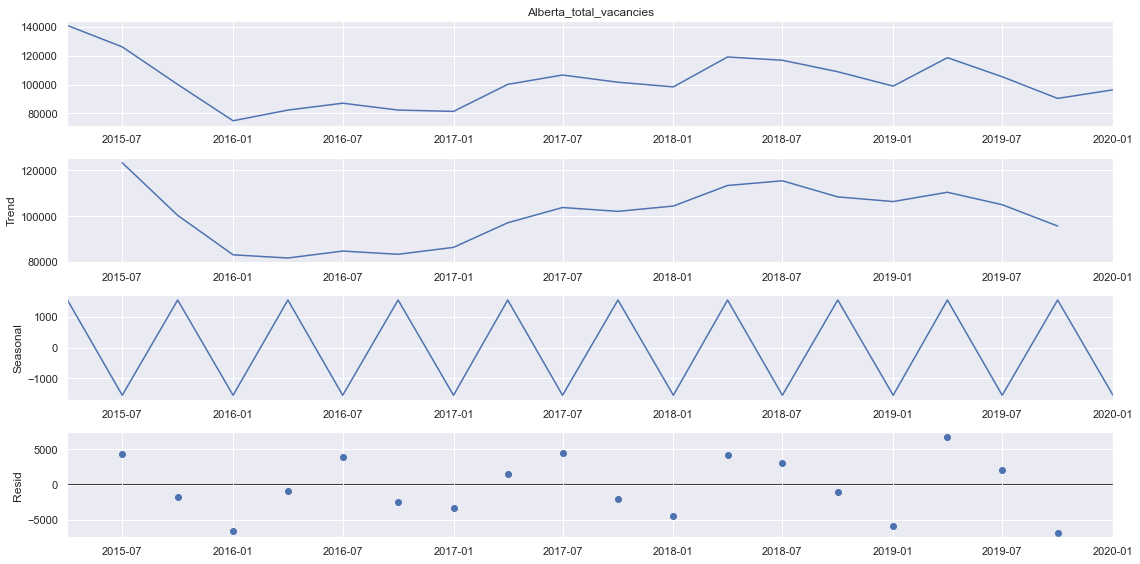

                                      SARIMAX Results                                      
Dep. Variable:                       train_Alberta   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -141.831
Date:                             Sun, 21 Nov 2021   AIC                            291.663
Time:                                     21:00:29   BIC                            293.922
Sample:                                 04-01-2015   HQIC                           291.198
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        736.5327   1795.761      0.410      0.682   -2783.093    4256.159
ar.S.L2       -0.9800      

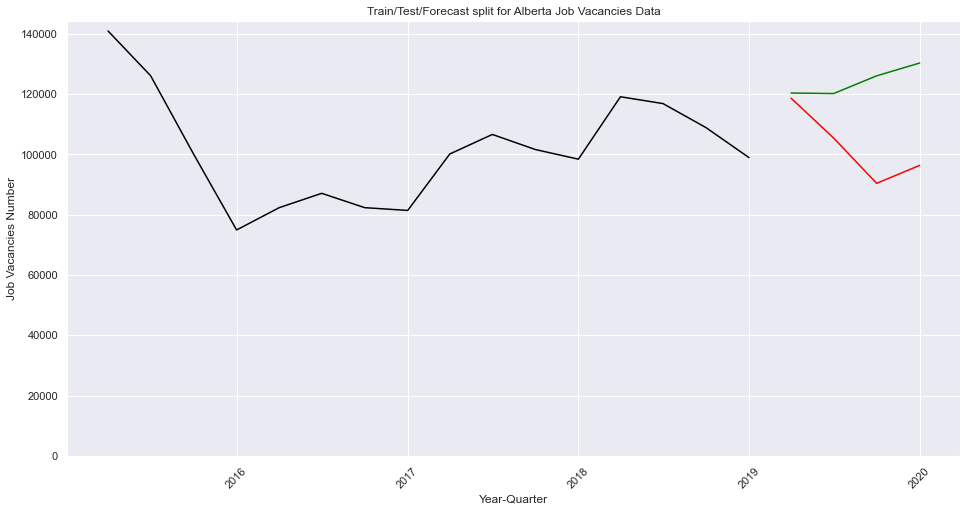

RMSE is 25703.162113499733
Stationary Test Results
      Values                       Metric
0   0.461182              Test Statistics
1   0.983644                      p-value
2   8.000000             No. of lags used
3  11.000000  Number of observations used
4  -4.223238          critical value (1%)
5  -3.189369          critical value (5%)
6  -2.729839         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.7260048390119982
Two Quaretrs Lag:  0.6163779289504382
Three Quaretrs Lag:  0.5200379997533287
Four Quaretrs Lag:  0.6018140490014824
Trend Decomposition Visualization


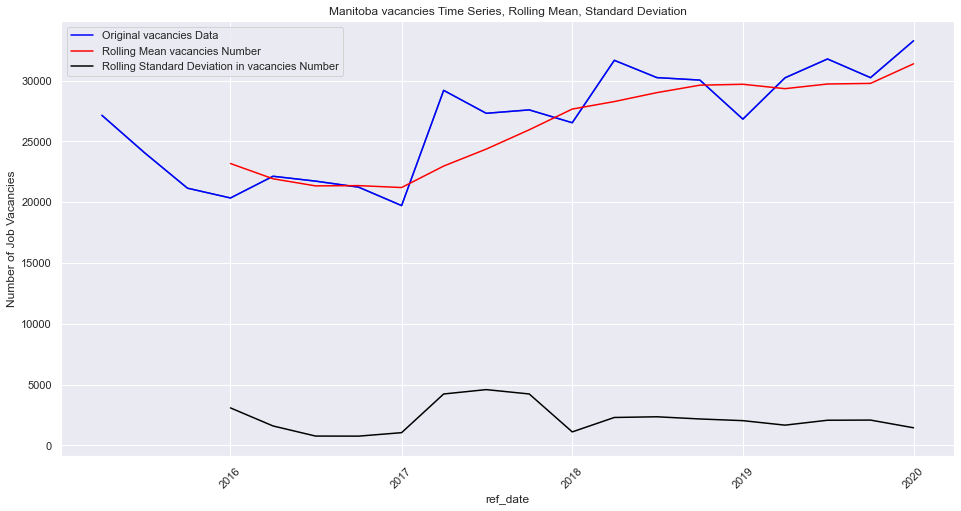

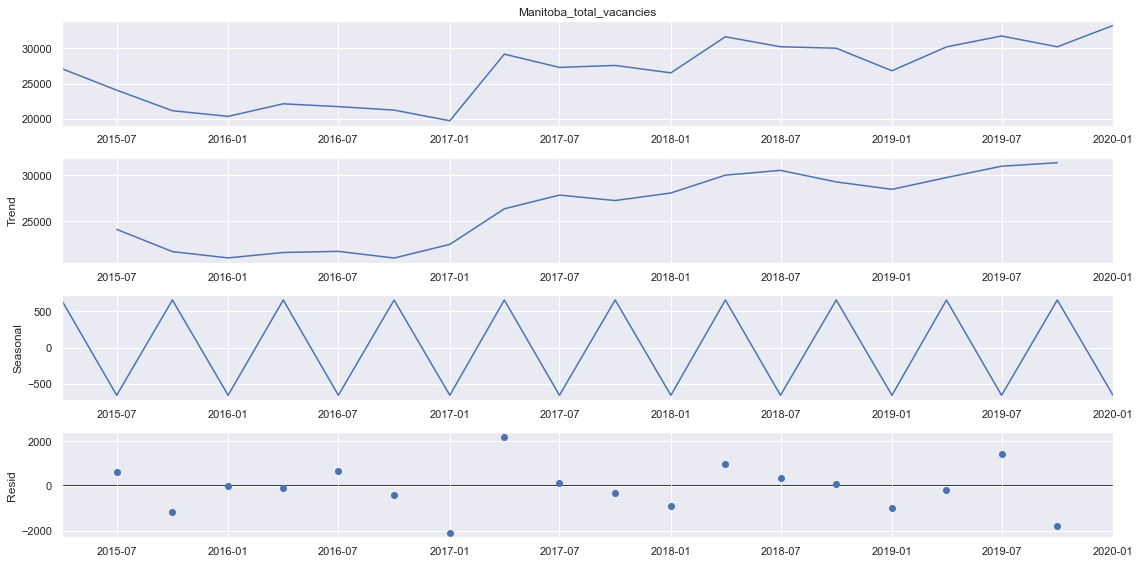

                                      SARIMAX Results                                      
Dep. Variable:                      train_Manitoba   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -121.614
Date:                             Sun, 21 Nov 2021   AIC                            251.229
Time:                                     21:00:30   BIC                            253.489
Sample:                                 04-01-2015   HQIC                           250.764
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        149.4149    288.240      0.518      0.604    -415.526     714.356
ar.S.L2       -0.9997      

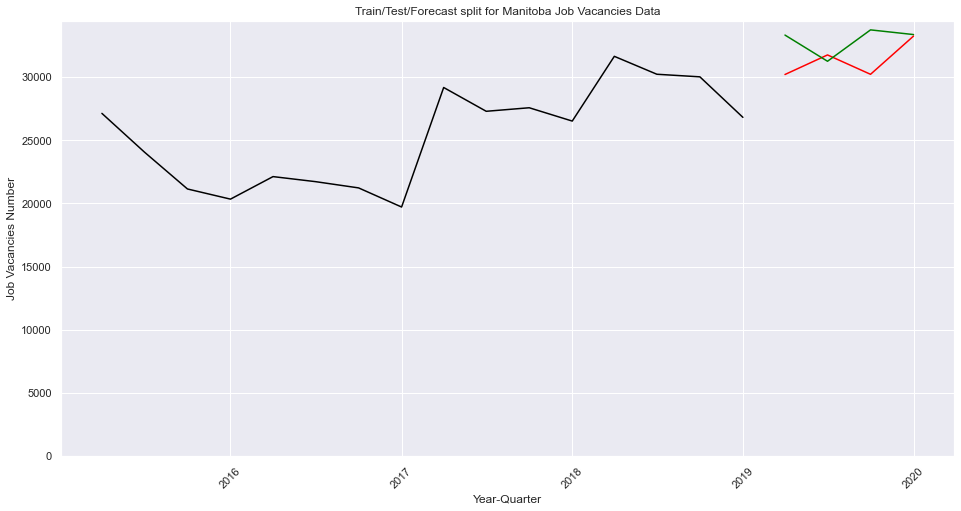

RMSE is 2367.4770872456124
Stationary Test Results
      Values                       Metric
0   1.762715              Test Statistics
1   0.998272                      p-value
2   7.000000             No. of lags used
3  12.000000  Number of observations used
4  -4.137829          critical value (1%)
5  -3.154972          critical value (5%)
6  -2.714477         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.3899083298630128
Two Quaretrs Lag:  -0.22434514316338458
Three Quaretrs Lag:  -0.1860240959850413
Four Quaretrs Lag:  0.22520329266805014
Trend Decomposition Visualization


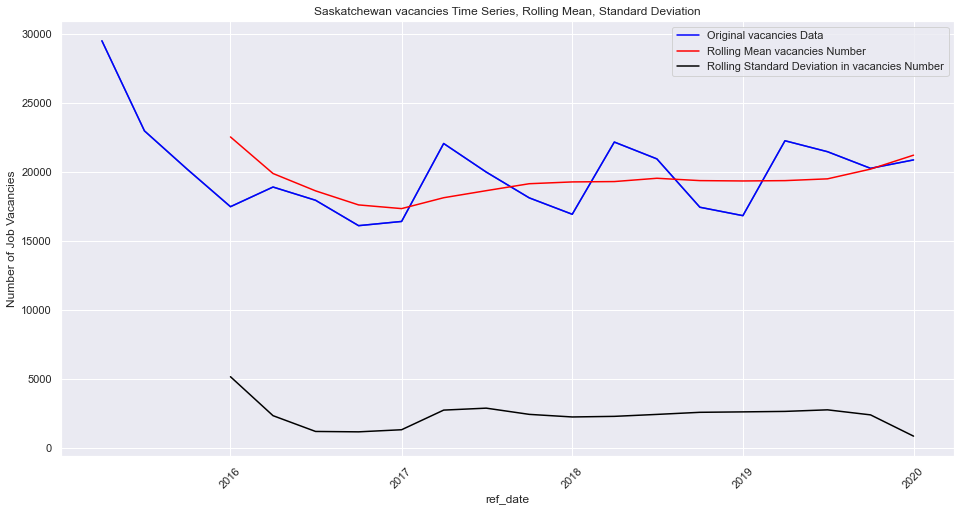

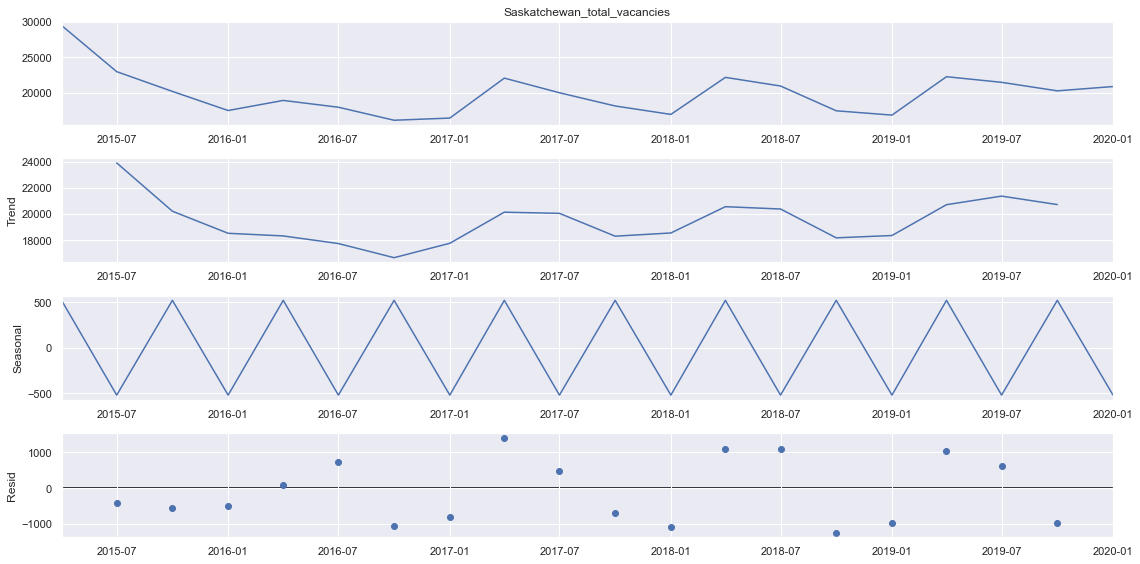

                                      SARIMAX Results                                      
Dep. Variable:                  train_Saskatchewan   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -125.287
Date:                             Sun, 21 Nov 2021   AIC                            258.574
Time:                                     21:00:32   BIC                            260.834
Sample:                                 04-01-2015   HQIC                           258.109
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -33.3398     63.718     -0.523      0.601    -158.226      91.546
ar.S.L2        0.1512      

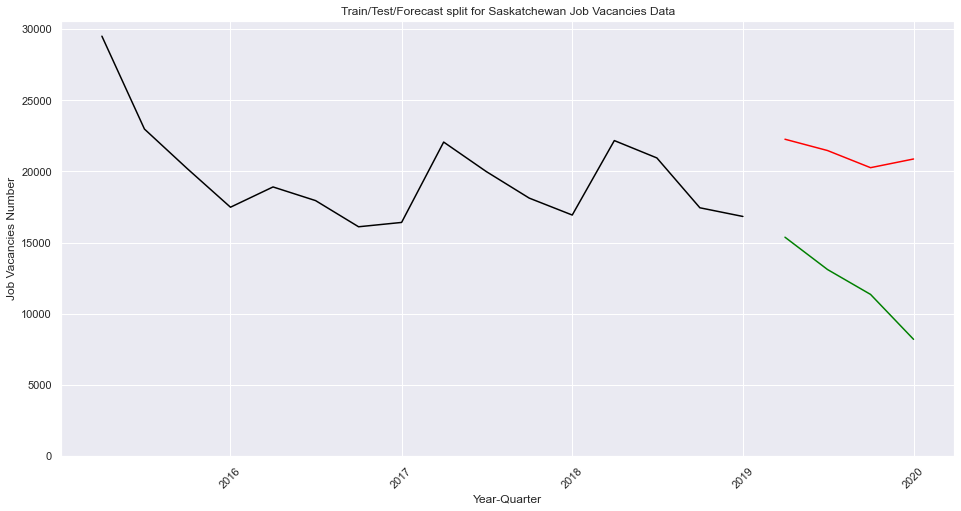

RMSE is 9454.572185048679
Stationary Test Results
      Values                       Metric
0  -1.219161              Test Statistics
1   0.665299                      p-value
2   8.000000             No. of lags used
3  11.000000  Number of observations used
4  -4.223238          critical value (1%)
5  -3.189369          critical value (5%)
6  -2.729839         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.5606213944972768
Two Quaretrs Lag:  0.24961780663030395
Three Quaretrs Lag:  0.25910425554065264
Four Quaretrs Lag:  0.6927665283172184
Trend Decomposition Visualization


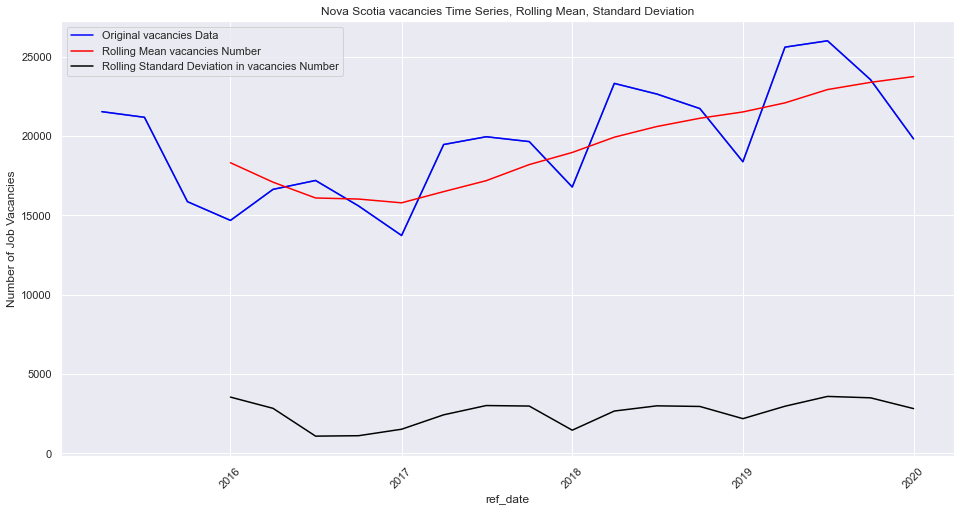

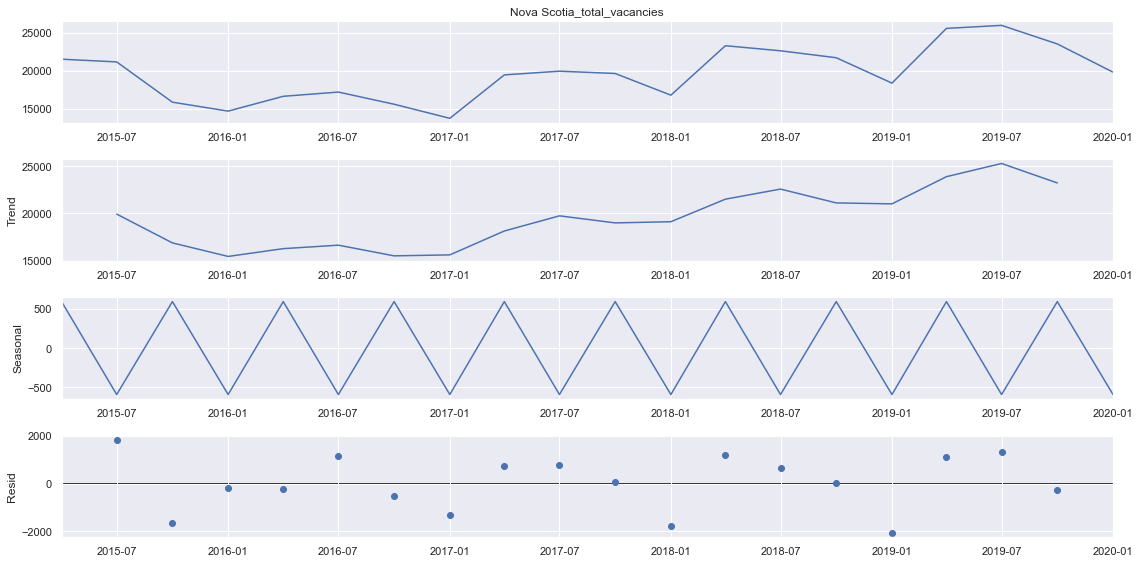

                                      SARIMAX Results                                      
Dep. Variable:                   train_Nova Scotia   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                   0.000
Date:                             Sun, 21 Nov 2021   AIC                              8.000
Time:                                     21:00:34   BIC                             10.260
Sample:                                 04-01-2015   HQIC                             7.536
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       8.914e+04         -0       -inf      0.000    8.91e+04    8.91e+04
ar.S.L2        1.0000   5.7

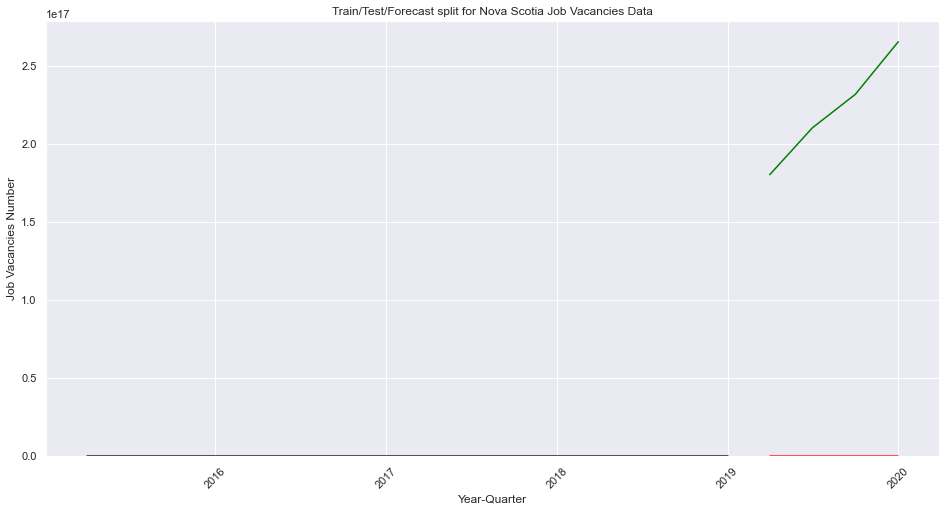

RMSE is 2.2430673111108205e+17
Stationary Test Results
      Values                       Metric
0  -2.554317              Test Statistics
1   0.102811                      p-value
2   8.000000             No. of lags used
3  11.000000  Number of observations used
4  -4.223238          critical value (1%)
5  -3.189369          critical value (5%)
6  -2.729839         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.5725875732415202
Two Quaretrs Lag:  0.3201240792090369
Three Quaretrs Lag:  0.29720501439488806
Four Quaretrs Lag:  0.7161878130371007
Trend Decomposition Visualization


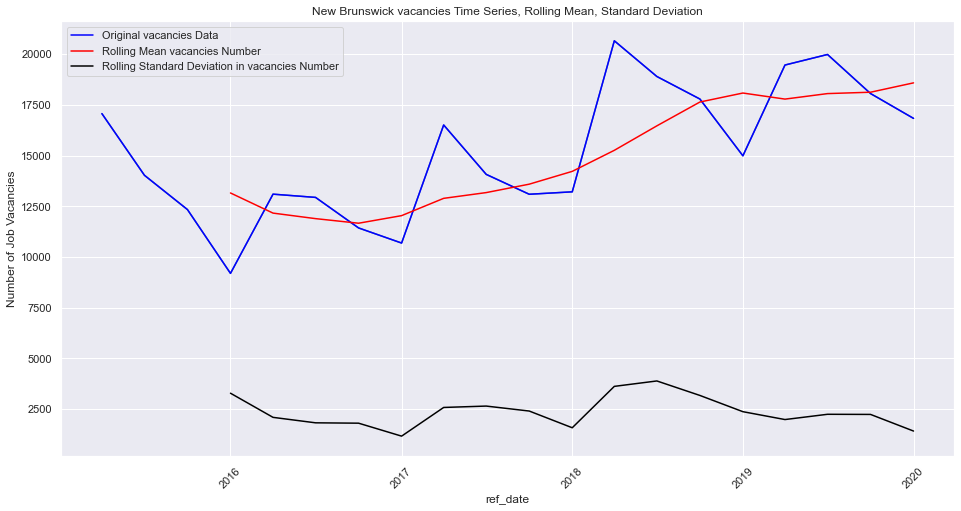

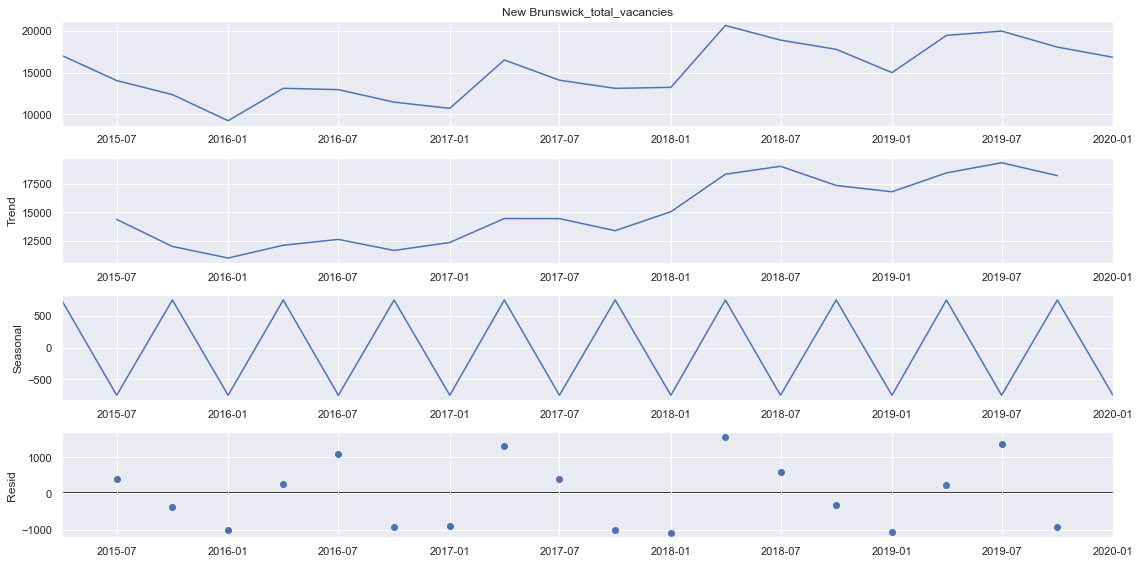

                                      SARIMAX Results                                      
Dep. Variable:                 train_New Brunswick   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -121.854
Date:                             Sun, 21 Nov 2021   AIC                            251.709
Time:                                     21:00:36   BIC                            253.969
Sample:                                 04-01-2015   HQIC                           251.244
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        175.9288    358.108      0.491      0.623    -525.951     877.808
ar.S.L2       -0.9938      

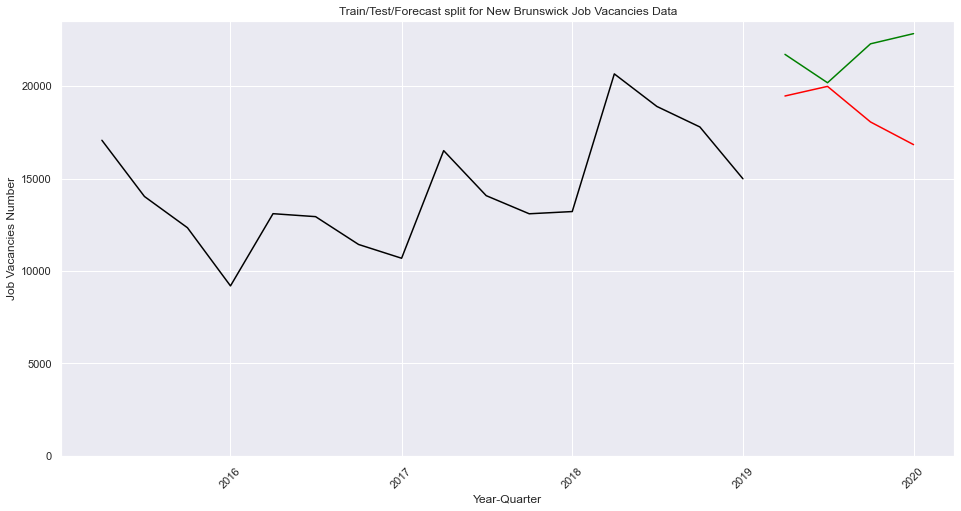

RMSE is 3840.804970994923
Stationary Test Results
      Values                       Metric
0   2.388992              Test Statistics
1   0.999005                      p-value
2   8.000000             No. of lags used
3  11.000000  Number of observations used
4  -4.223238          critical value (1%)
5  -3.189369          critical value (5%)
6  -2.729839         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.44457384743866873
Two Quaretrs Lag:  0.19999070807236954
Three Quaretrs Lag:  -0.054164131286709195
Four Quaretrs Lag:  0.29419363750604494
Trend Decomposition Visualization


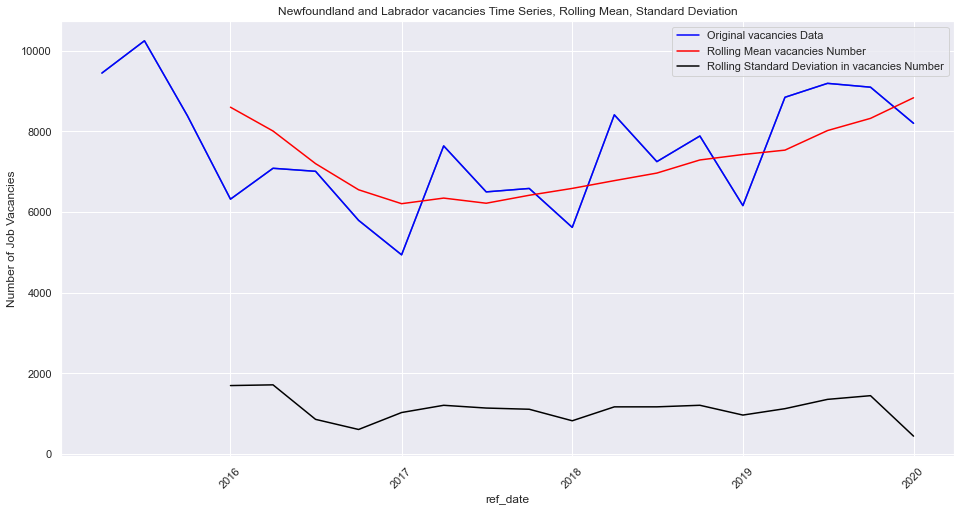

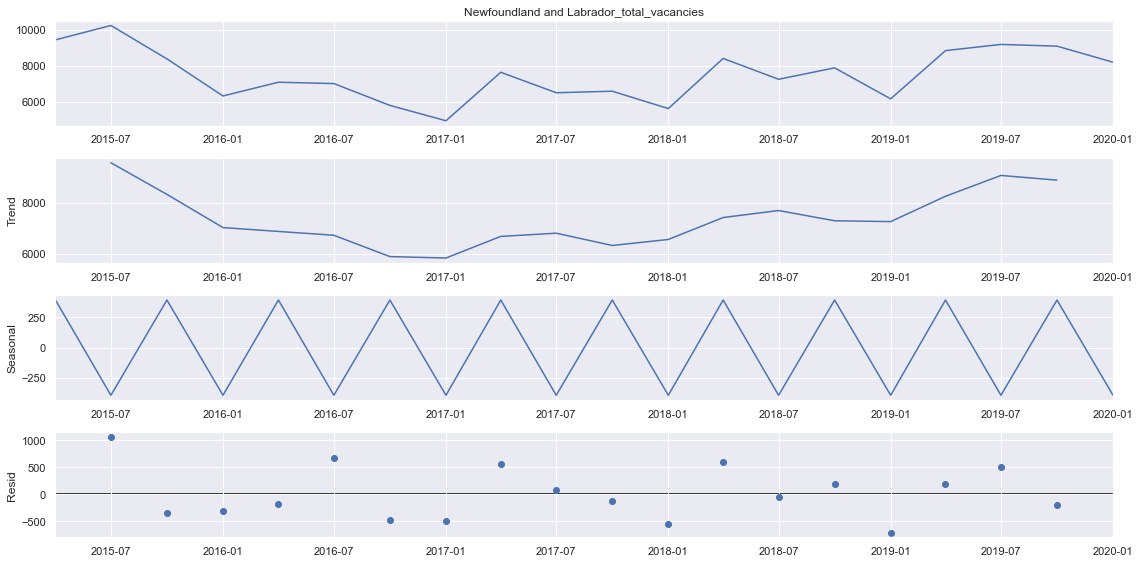

                                      SARIMAX Results                                      
Dep. Variable:     train_Newfoundland and Labrador   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -108.567
Date:                             Sun, 21 Nov 2021   AIC                            225.133
Time:                                     21:00:38   BIC                            227.393
Sample:                                 04-01-2015   HQIC                           224.669
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          5.7101     74.726      0.076      0.939    -140.750     152.170
ar.S.L2       -0.9318      

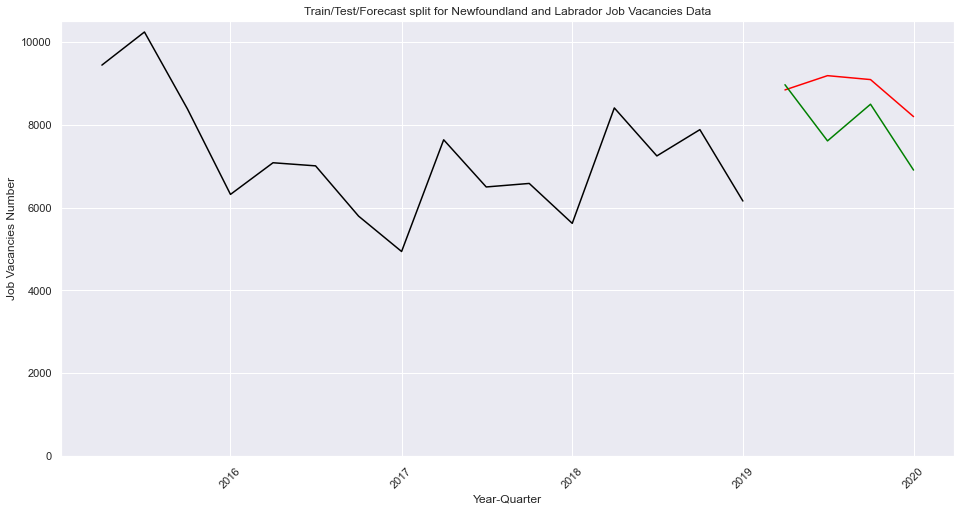

RMSE is 1063.7581777467162
Stationary Test Results
         Values                       Metric
0 -7.078793e+00              Test Statistics
1  4.725283e-10                      p-value
2  8.000000e+00             No. of lags used
3  1.100000e+01  Number of observations used
4 -4.223238e+00          critical value (1%)
5 -3.189369e+00          critical value (5%)
6 -2.729839e+00         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.2904441840381243
Two Quaretrs Lag:  -0.07381217869505494
Three Quaretrs Lag:  0.1280720190924778
Four Quaretrs Lag:  0.7520888183154066
Trend Decomposition Visualization


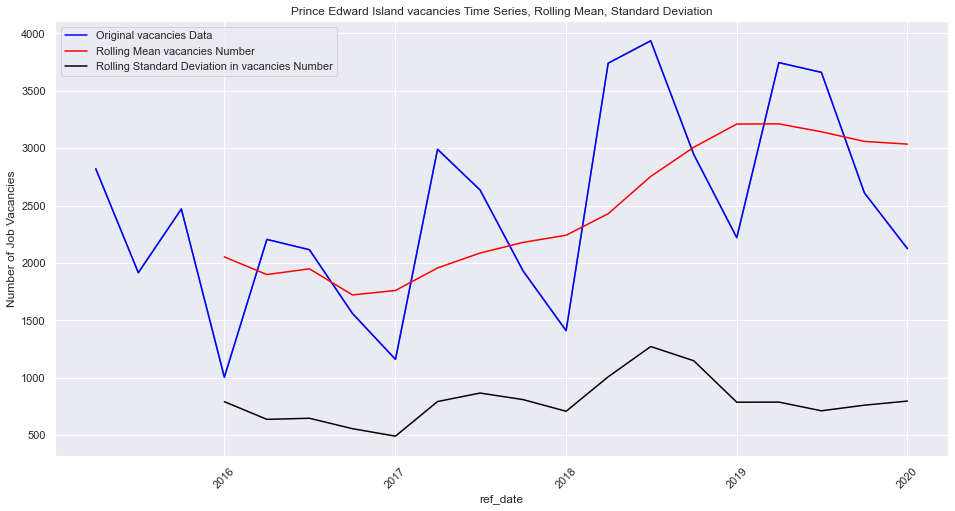

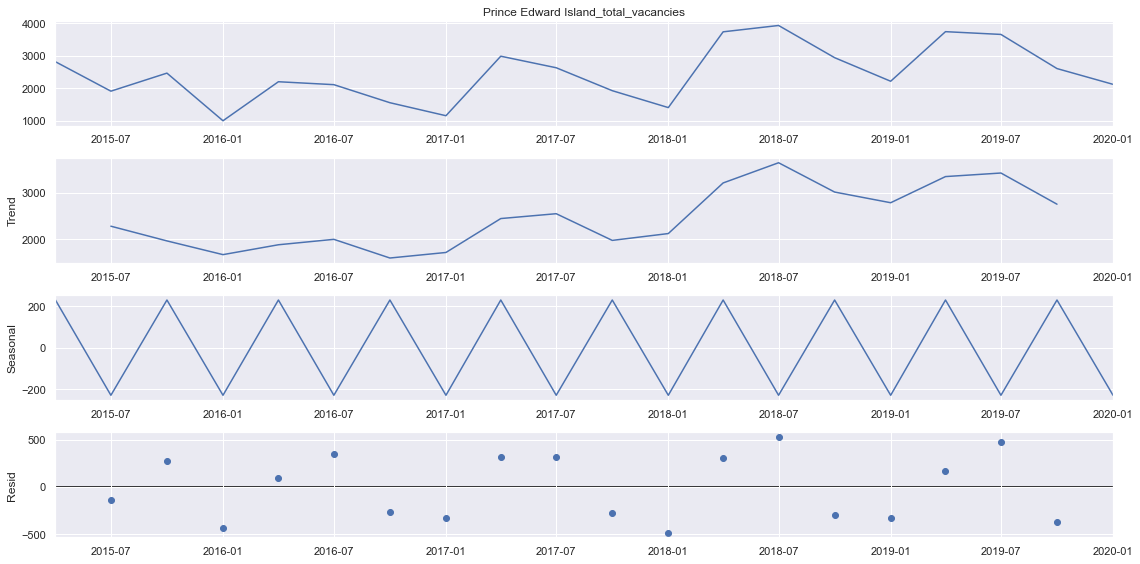

                                      SARIMAX Results                                      
Dep. Variable:          train_Prince Edward Island   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -103.625
Date:                             Sun, 21 Nov 2021   AIC                            215.251
Time:                                     21:00:40   BIC                            217.510
Sample:                                 04-01-2015   HQIC                           214.786
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          9.9942     20.262      0.493      0.622     -29.719      49.707
ar.S.L2       -1.0000      

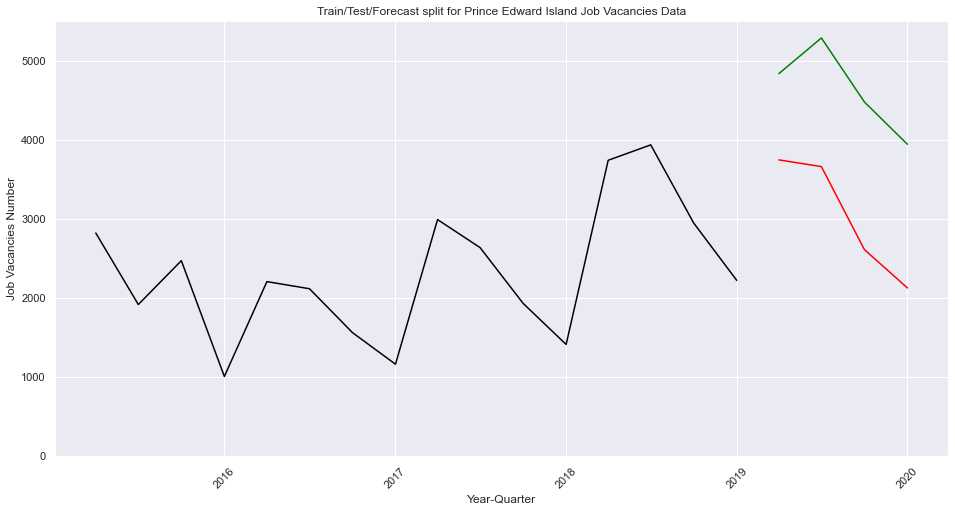

RMSE is 1630.1976155585626
Stationary Test Results
      Values                       Metric
0 -23.006393              Test Statistics
1   0.000000                      p-value
2   8.000000             No. of lags used
3  11.000000  Number of observations used
4  -4.223238          critical value (1%)
5  -3.189369          critical value (5%)
6  -2.729839         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.27445244027177074
Two Quaretrs Lag:  -0.02198604081403245
Three Quaretrs Lag:  0.18019300133230226
Four Quaretrs Lag:  0.3977079130737085
Trend Decomposition Visualization


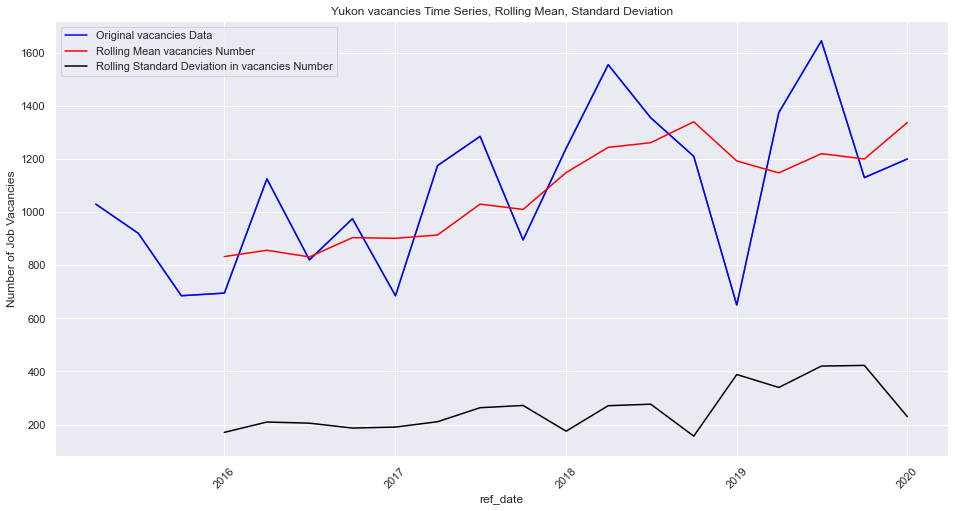

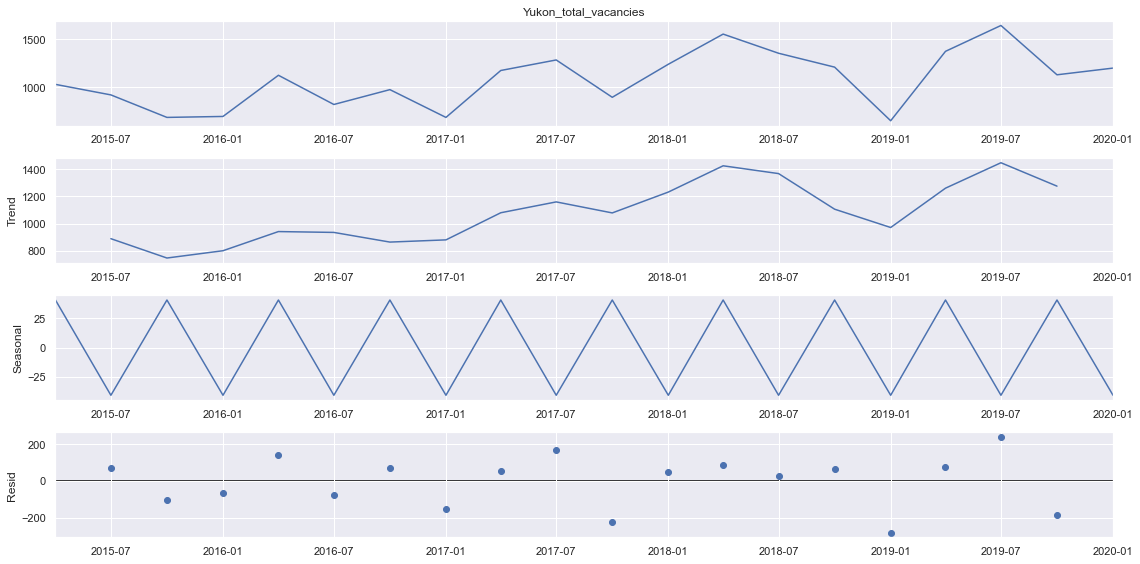

                                      SARIMAX Results                                      
Dep. Variable:                         train_Yukon   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                 -94.295
Date:                             Sun, 21 Nov 2021   AIC                            196.590
Time:                                     21:00:42   BIC                            198.850
Sample:                                 04-01-2015   HQIC                           196.126
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -11.2750     14.683     -0.768      0.443     -40.053      17.503
ar.S.L2       -1.0000      

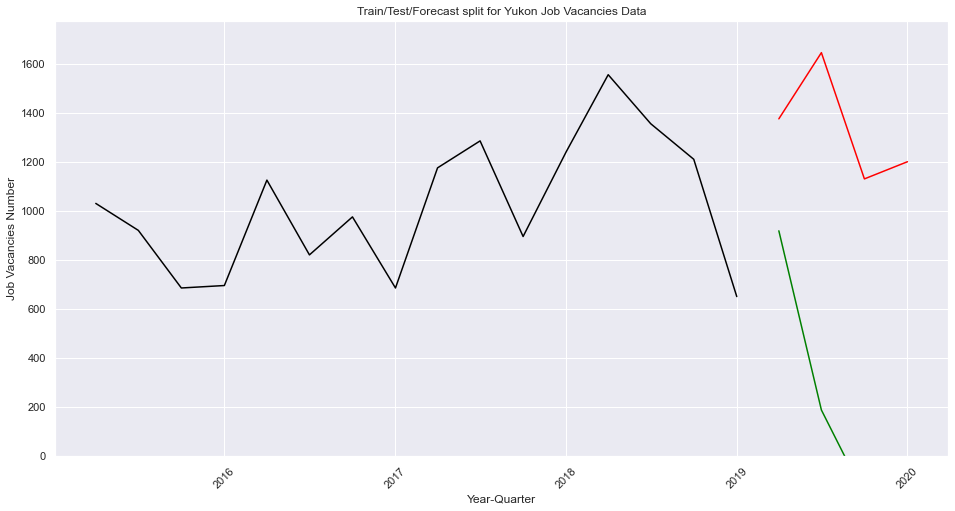

RMSE is 1462.6177359571086
Stationary Test Results
         Values                       Metric
0 -1.730453e+01              Test Statistics
1  5.602411e-30                      p-value
2  8.000000e+00             No. of lags used
3  1.100000e+01  Number of observations used
4 -4.223238e+00          critical value (1%)
5 -3.189369e+00          critical value (5%)
6 -2.729839e+00         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.503008783046242
Two Quaretrs Lag:  0.2366823739012541
Three Quaretrs Lag:  0.3115515795178819
Four Quaretrs Lag:  0.4092857827624349
Trend Decomposition Visualization


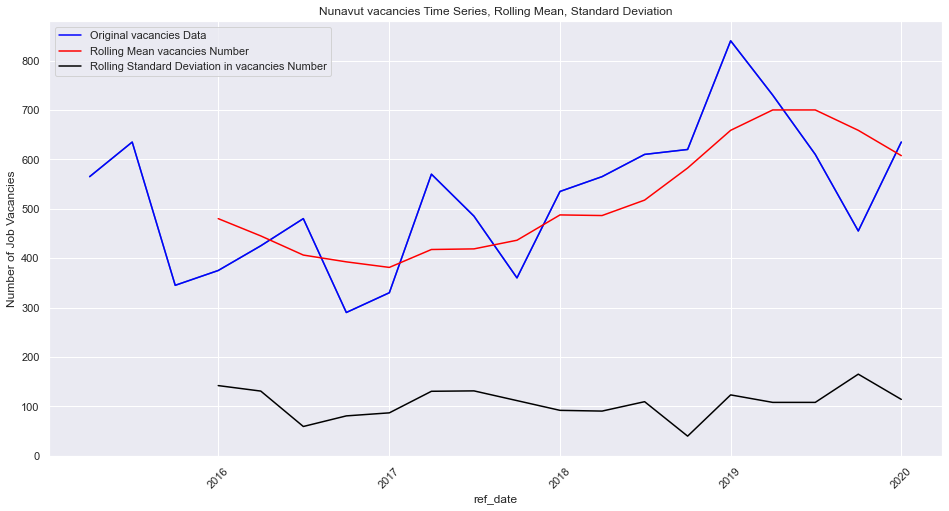

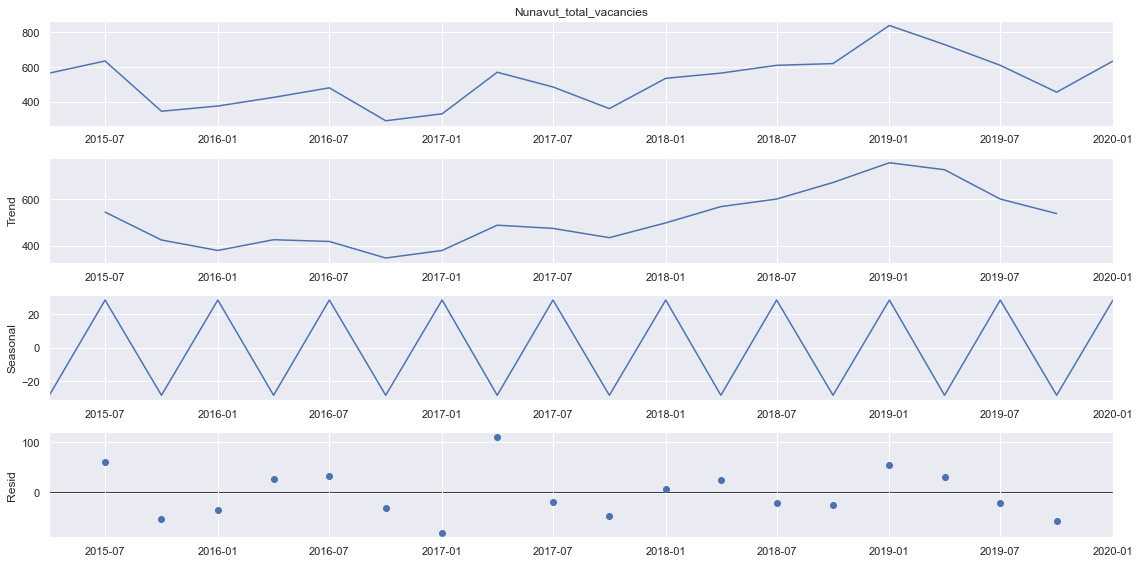

                                      SARIMAX Results                                      
Dep. Variable:                       train_Nunavut   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                 -79.946
Date:                             Sun, 21 Nov 2021   AIC                            167.891
Time:                                     21:00:44   BIC                            170.151
Sample:                                 04-01-2015   HQIC                           167.427
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          3.1570      2.155      1.465      0.143      -1.067       7.381
ar.S.L2       -0.6943      

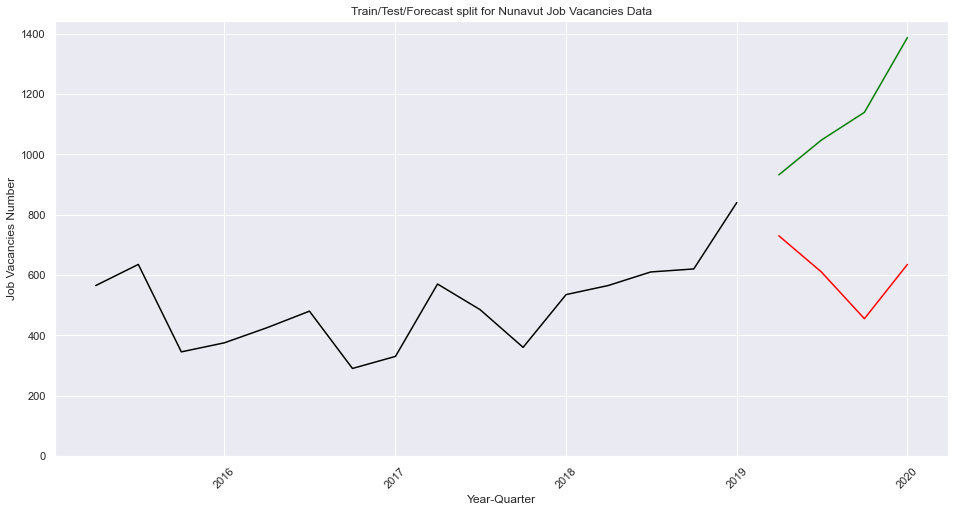

RMSE is 562.6679393135379
Stationary Test Results
      Values                       Metric
0  -3.224138              Test Statistics
1   0.018629                      p-value
2   0.000000             No. of lags used
3  19.000000  Number of observations used
4  -3.832603          critical value (1%)
5  -3.031227          critical value (5%)
6  -2.655520         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.08172342773656963
Two Quaretrs Lag:  -0.04213939974568735
Three Quaretrs Lag:  -0.036380772300447034
Four Quaretrs Lag:  -0.18102363608509214
Trend Decomposition Visualization


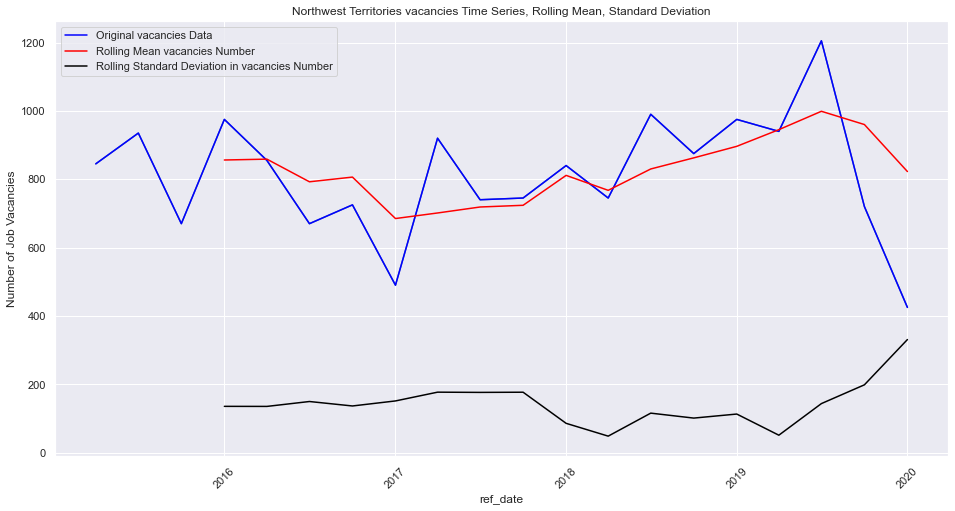

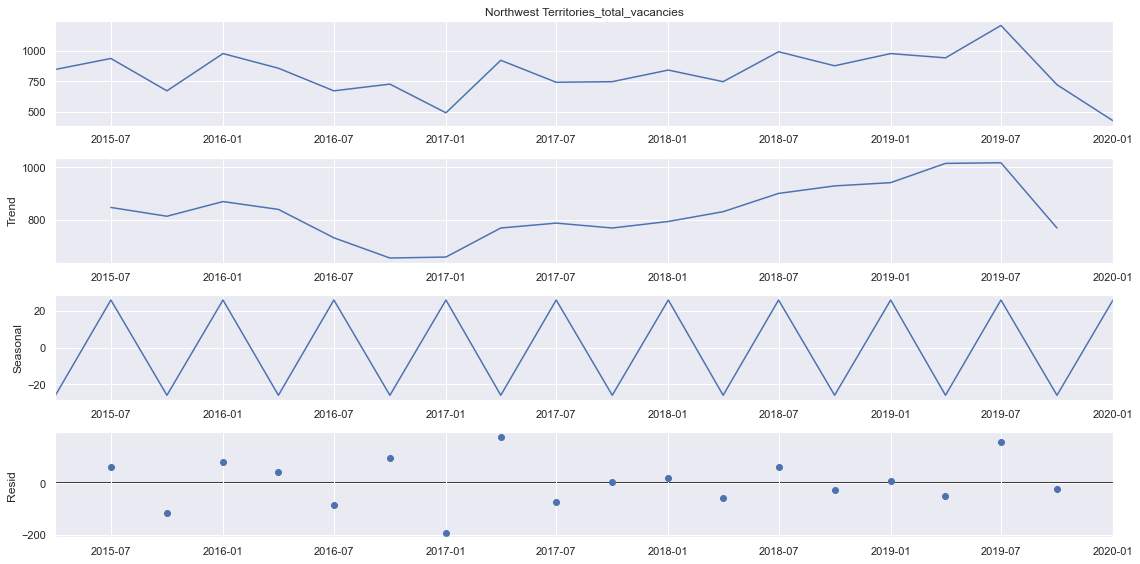

                                      SARIMAX Results                                      
Dep. Variable:         train_Northwest Territories   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                 -88.770
Date:                             Sun, 21 Nov 2021   AIC                            185.540
Time:                                     21:00:45   BIC                            187.800
Sample:                                 04-01-2015   HQIC                           185.076
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.5652      4.284      0.132      0.895      -7.832       8.963
ar.S.L2        0.4188      

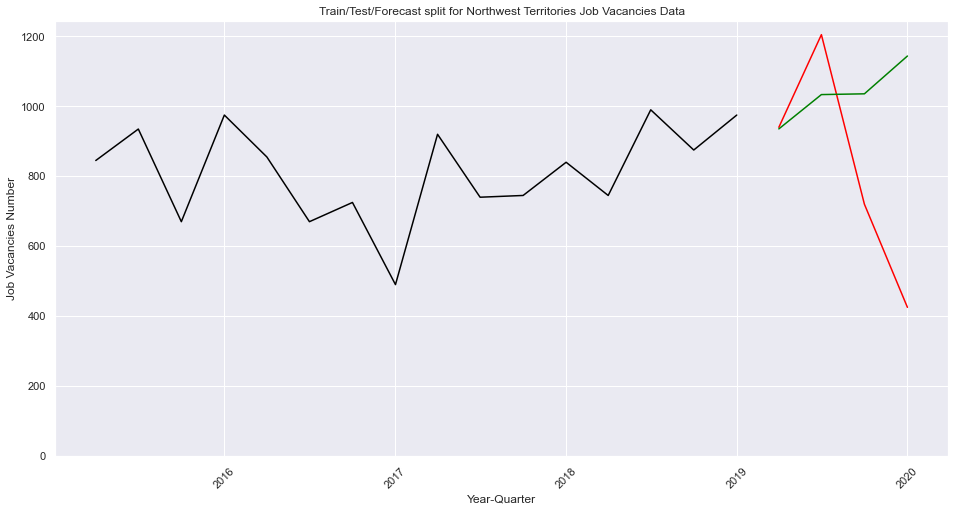

RMSE is 401.8437802591894
            test_Northwest Territories  Prediction_Northwest Territories  \
ref_date                                                                   
2019-04-01                       940.0                        935.419822   
2019-07-01                      1205.0                       1033.580838   
2019-10-01                       720.0                       1035.760941   
2020-01-01                       425.0                       1143.890267   
2019-04-01                         NaN                               NaN   
2019-07-01                         NaN                               NaN   
2019-10-01                         NaN                               NaN   
2020-01-01                         NaN                               NaN   
2019-04-01                         NaN                               NaN   
2019-07-01                         NaN                               NaN   
2019-10-01                         NaN                        

In [197]:
# produce all provinces prediction test results
provinces = ['Ontario', 'Quebec', 'British Columbia','Alberta',\
             'Manitoba', 'Saskatchewan','Nova Scotia', 'New Brunswick','Newfoundland and Labrador',\
             'Prince Edward Island', 'Yukon', 'Nunavut' ,'Northwest Territories']

output_provencies= []
for prov in provinces:
    x= province_vac(prov)
    output_provencies= x.append(output_provencies)
    
#output_provencies
print(output_provencies)

In [190]:
output_provencies.head(25)

,test_Northwest Territories,Prediction_Northwest Territories,test_Nunavut,Prediction_Nunavut,test_Yukon,Prediction_Yukon,test_Prince Edward Island,Prediction_Prince Edward Island,test_Newfoundland and Labrador,Prediction_Newfoundland and Labrador,...,test_Manitoba,Prediction_Manitoba,test_Alberta,Prediction_Alberta,test_British Columbia,Prediction_British Columbia,test_Quebec,Prediction_Quebec,test_Ontario,Prediction_Ontario
ref_date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,940.0,935.419822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01,1205.0,1033.580838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,720.0,1035.760941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,425.0,1143.890267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,730.0,932.024210,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01,NaN,NaN,610.0,1047.406407,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,NaN,NaN,455.0,1139.308446,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,NaN,NaN,635.0,1387.306217,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN,1375.0,918.187716,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
# close connection to DB
conn.close()